In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import json
import random
from tqdm.auto import tqdm
import pickle
from utils_functions import *

In [ ]:
bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()

uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
len(existing_proteins_list)
existing_proteins_list

In [5]:
filtered_df = bio_df[existing_proteins_list]
filtered_df

,A0A0G2JE99,A0A286YCX6,A2AF47,A2AIV8,A2AM29,A2APB8,A2APC3,A2APY7,A2AQ07,A2AR02,...,Q9Z1Z2,Q9Z2D0,Q9Z2D1,Q9Z2D3,Q9Z2I9,Q9Z2M7,Q9Z2V5,Q9Z2X1,Q9Z2X2,Q9Z2Z9
0,0,162010.0,125760.0,0.0,15104.0,109740.0,67069.00,27275.0,40522.0,273390,...,2494000,20249.0,176690,255050,69902.0,175920,198910,6838400,393630,173190.0
1,0,167320.0,0.0,0.0,8574.6,116490.0,88118.00,31187.0,40570.0,217250,...,2334000,22413.0,167940,308010,69789.0,172240,216860,6752500,442120,83790.0
2,0,51649.0,0.0,0.0,10085.0,49893.0,124690.00,92364.0,39478.0,19164,...,2063700,2293.4,115320,86602,2482.1,37705,207340,5448300,359080,0.0
3,28979,13440.0,52032.0,0.0,12123.0,159700.0,0.00,33011.0,26715.0,271680,...,2174900,5152.3,115790,129890,108690.0,367500,109640,6404800,252500,162590.0
4,0,159740.0,0.0,0.0,6523.1,44042.0,77081.00,45720.0,57331.0,213460,...,2318300,19318.0,147760,204760,122880.0,306030,191870,6147200,443340,266710.0
5,0,103780.0,0.0,0.0,13429.0,164280.0,52180.00,69290.0,50447.0,160470,...,2122600,9910.4,88441,291390,76940.0,373750,118760,6005900,236300,228000.0
6,0,126620.0,59234.0,0.0,6477.1,28037.0,0.00,17809.0,32387.0,250090,...,1766100,15817.0,38631,158870,73311.0,197240,130020,4152700,385540,3416.8
7,0,132010.0,17986.0,0.0,5812.8,95160.0,42151.00,39341.0,48215.0,140010,...,1823100,6913.5,63605,130250,86056.0,206880,134410,4727300,306190,0.0
8,0,65848.0,0.0,9401.6,6586.5,43317.0,0.00,13514.0,45938.0,275070,...,1505500,1436.6,26911,147490,183430.0,190910,159600,5192100,301570,0.0
9,0,161540.0,21179.0,0.0,3319.8,31962.0,0.00,20161.0,34026.0,225620,...,1560900,4941.0,49929,160390,157680.0,196000,108290,4975300,467760,429350.0


## queries that may be useful

```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel1]-()-[rel2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(DISTINCT rel1) + collect(DISTINCT rel2) AS relationships, collect(DISTINCT connectedNodes) AS nodes
```



```cypher
UNWIND $proteinNames AS proteinName
MATCH path = (p)-[*2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, [r in relationships(path) | r] AS relationships, collect(DISTINCT connectedNodes) AS nodes
LIMIT 2
```




```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p))
  AND ANY(name IN p.name WHERE name = proteinName)
CALL apoc.path.subgraphAll(p, {
  maxLevel: 2,
  relationshipFilter: ">", // Adjust this based on your relationship types
  labelFilter: "/Mus musculus", // Adjust this to filter the end nodes, use + for include, - for exclude
  endNodeFilter: "Mus musculus" // This is not a native option, demonstrating intent
})
YIELD nodes, relationships
RETURN p AS protein, nodes, relationships
```





```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND connectedNodes.speciesName = 'Mus musculus' AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(rel) AS relationships, collect(connectedNodes) AS nodes
```


        MATCH (p {dbId: '9896799'})-[rel]-(connectedNodes)
        WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND connectedNodes.speciesName = 'Mus musculus'
        RETURN connectedNodes
        limit 2




MATCH (protein)
WHERE ('EntityWithAccessionedSequence' IN labels(protein) OR 'GenomeEncodedEntity' IN labels(protein))
  AND ANY(name IN protein.name WHERE name = "A2AF47")
CALL apoc.path.expand(
  protein, 
  null,
  null,
  1, 
  2
) YIELD path
WITH protein, 
     [node IN nodes(path) WHERE node.speciesName = 'Mus musculus'] AS filteredNodes,
     relationships(path) AS allRelationships
UNWIND filteredNodes AS fn
WITH protein, COLLECT(DISTINCT fn) AS uniqueFilteredNodes, allRelationships
RETURN protein AS P, uniqueFilteredNodes AS Nodes, allRelationships AS Relationships
        

# Extract connected nodes to the specific proteins from reactome using neo4j

In [ ]:
from tqdm import tqdm
import pickle



def fetch_and_create_graph(driver, protein_names, batch_size=10):
    num_batches = len(protein_names) // batch_size + (1 if len(protein_names) % batch_size > 0 else 0)
    G = nx.MultiGraph()

    
    with driver.session() as session:
        for i in tqdm(range(num_batches), desc="Processing batches"):
            batch = protein_names[i * batch_size : (i + 1) * batch_size]
            try:
                for record in session.run("""
                    UNWIND $proteinNames AS proteinName
                    MATCH (p)
                    WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND p.speciesName = 'Mus musculus'
                      AND ANY(name IN p.name WHERE name = proteinName)
                    CALL apoc.path.subgraphAll(p, {
                      maxLevel: 2,
                      minLevel:1
                    })
                    YIELD nodes, relationships
                    WITH p, 
                         [node in nodes WHERE node.speciesName = 'Mus musculus'] AS filteredNodes,
                         relationships
                    RETURN p AS protein, filteredNodes AS nodes, relationships
                """, {"proteinNames": batch}):
                    protein_node = record['protein']
                    if protein_node and protein_node._properties:
                        G.add_node(protein_node.element_id, **protein_node._properties)
                    for node in record['nodes']:
                        if node and node._properties:
                            G.add_node(node.element_id, **node._properties)
                        else:
                            print(f"Node {node.element_id} has no properties.")  
                    for rel in record['relationships']:
                        if rel and rel._properties:
                            G.add_edge(rel.start_node.id, rel.end_node.id, **rel._properties)
            except Exception as e:
                print(f"An error occurred: {e}")

    return G


    
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "123456789"))


G = fetch_and_create_graph(driver, existing_proteins_list[0:30])
nodes_without_attrs = []
count = 1
for node, attrs in G.nodes(data=True):
    if not attrs:
        print(node)
        nodes_without_attrs.append(node)
    elif attrs:
            count+=1

print("numnber of nodes without attributes", len(nodes_without_attrs))
print("number of nodes with attributes",count)
driver.close()
with open("aggregated_proteins_v10-20_subgraph_latest.pkl", "wb") as f:
    pickle.dump(aggregated_graph, f)



# Graph Data Analysis

In [ ]:

        
G = load_graph_from_pickle('combined_graph_latest.pkl')
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


def remove_nodes_without_attributes(graph):
    # Find nodes without attributes
    nodes_to_remove = [node for node, attrs in graph.nodes(data=True) if not attrs]
    
    # Remove the identified nodes and their connected edges
    for node in nodes_to_remove:
        graph.remove_node(node)


# Call the function to modify the graph
remove_nodes_without_attributes(G)

# Display the graph after nodes without attributes have been removed
print("\nAfter removal:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
# # Find connected components
connected_components = list(nx.connected_components(G))

# Print connected components
for i, component in enumerate(connected_components, 1):
    print(f"Component {i}: {len(component)}")

# Degree distribution plot

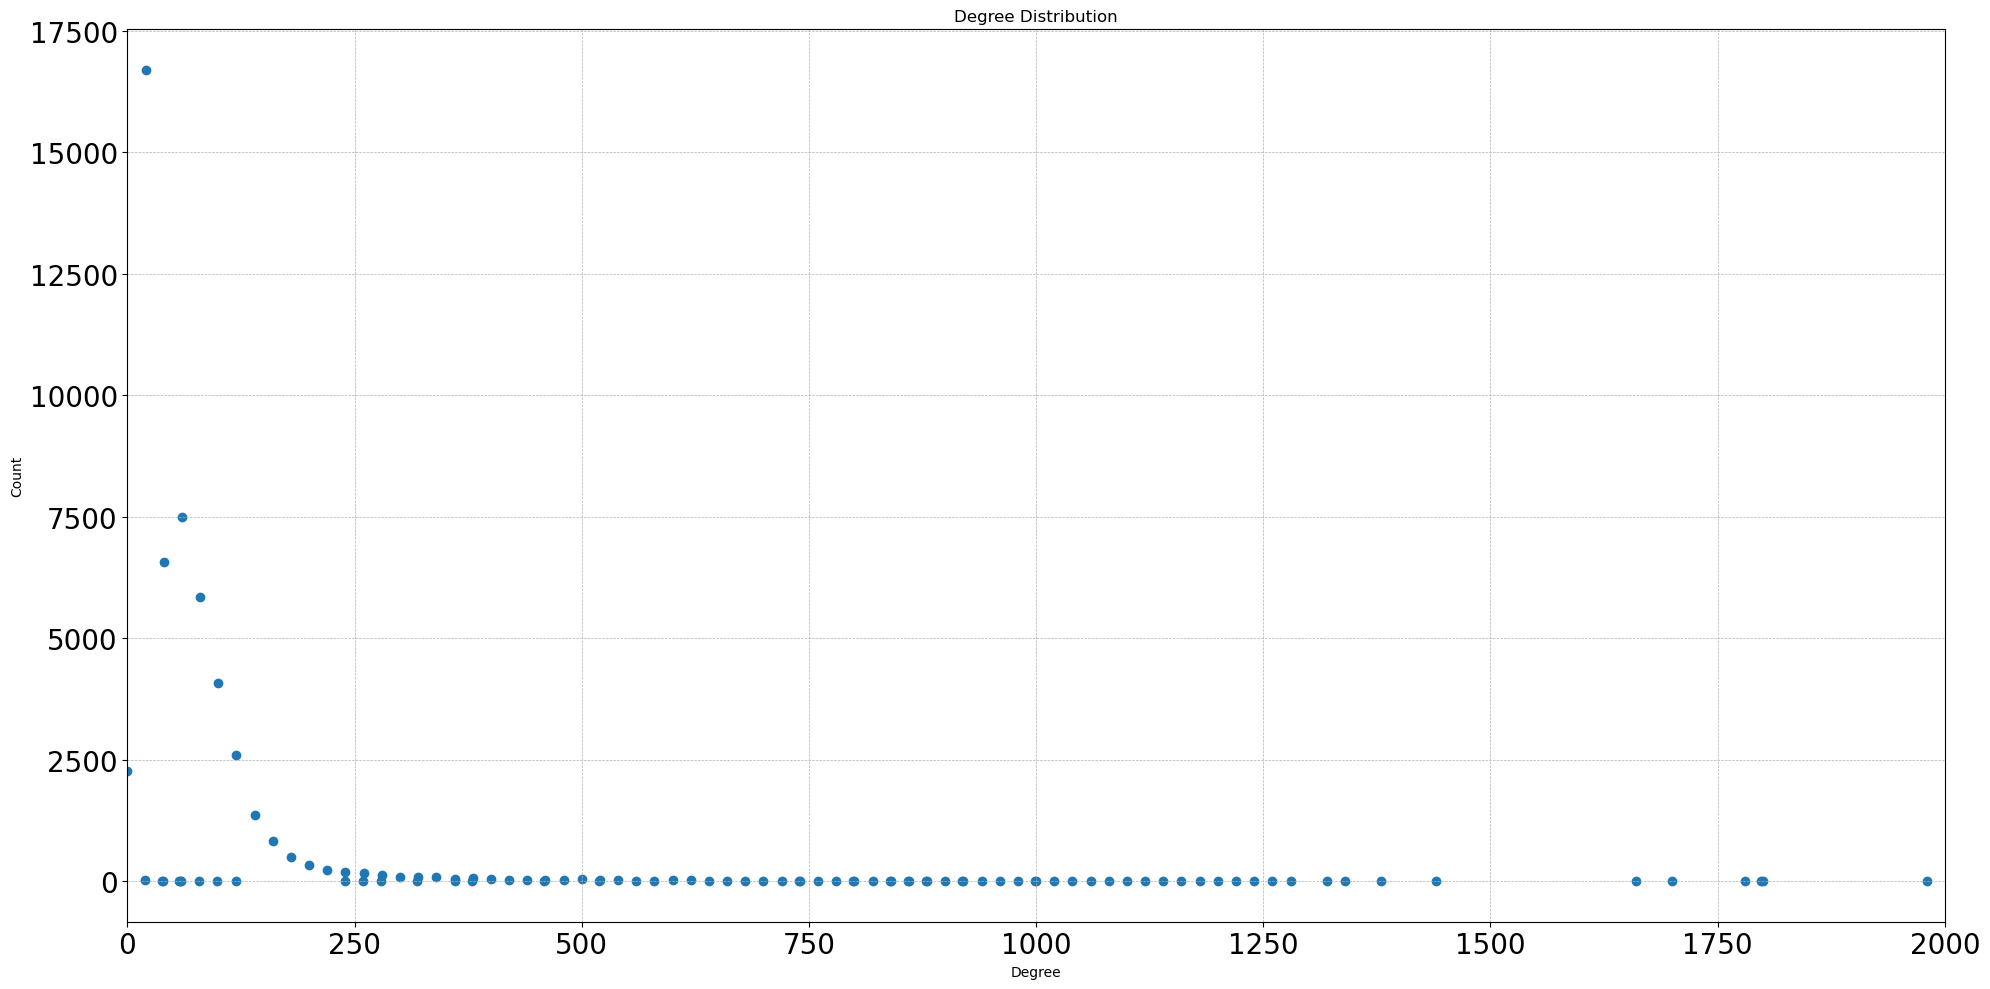

In [55]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import numpy as np


degree_sequence = dict(G.degree()).values()
degree_count = Counter(degree_sequence)

degrees, counts = zip(*degree_count.items())


plt.figure(figsize=(20, 10))  
# plt.bar(degrees, counts, color='blue')  
plt.scatter(degrees, counts)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 2000)
# plt.ylim(bottom=1)

plt.tight_layout()

plt.show()

In [26]:
# import networkx as nx
# from torch_geometric.utils import from_networkx

# G = nx.read_graphml('aggregated_proteins_v2.graphml')

# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)


In [12]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
import numpy as np

G = nx.read_graphml('aggregated_proteins_v30.graphml')


def preprocess_features(features):
    # Convert features to a numeric format, handle non-numeric cases
    processed_features = []
    for feature in features:
        try:
            # convert the features to float
            processed_features.append(float(feature))
        except ValueError:
            # Handle non-numeric feature (could implement encoding here)
            processed_features.append(0.0)  # Using 0.0 as a placeholder
    return processed_features

def normalize_features(features):
    features = np.array(features)
    mean = features.mean(axis=0, keepdims=True)
    std = features.std(axis=0, keepdims=True)
    # Avoid division by zero
    std[std == 0] = 1
    normalized_features = (features - mean) / std
    return normalized_features.tolist()

def from_networkx_to_torch_geometric(G):
    # Convert node indices to a continuous range
    mapping = {k: i for i, k in enumerate(G.nodes())}
    edges = torch.tensor([list(map(mapping.get, edge)) for edge in G.edges()], dtype=torch.long).t().contiguous()
    
    if G.nodes():
        # Extract a sample node to get feature keys (assumes at least one node exists)
        sample_features = next(iter(G.nodes(data=True)))[1]
        feature_keys = list(sample_features.keys())
        
        # Extract and preprocess features for all nodes
        features = []
        for _, node_features in G.nodes(data=True):
            node_feature_values = [node_features.get(key, 0) for key in feature_keys]
            processed_features = preprocess_features(node_feature_values)
            features.append(processed_features)
        
        # Normalize features
        features = normalize_features(features)
    else:
        # Default to a single feature of 0 if no nodes or features
        features = [[0]]

    # Convert features to a tensor
    x = torch.tensor(features, dtype=torch.float)

    # Create the Data object
    data = Data(x=x, edge_index=edges)
    
    return data

def create_masks_for_node_classification(data, train_percent=0.6, val_percent=0.2):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_percent)
    num_val = int(num_nodes * val_percent)

    # Shuffle node indices
    indices = torch.randperm(num_nodes)

    # Assign masks
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:num_train]] = True
    data.val_mask[indices[num_train:num_train + num_val]] = True
    data.test_mask[indices[num_train + num_val:]] = True

    return data


    
# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)

data = from_networkx_to_torch_geometric(G)
# data = create_masks_for_node_classification(data)

# Creating a custom dataset
class CustomGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CustomGraphDataset, self).__init__()
        self.data_list = data_list
    
    def len(self):
        return len(self.data_list)
    
    def get(self, idx):
        return self.data_list[idx]

# Assuming you have a list of Data objects, you can create a dataset like this:
dataset = CustomGraphDataset([data])

# Example usage
loader = DataLoader(dataset, batch_size=1, shuffle=True)

print(data)

Data(x=[50164, 11], edge_index=[2, 2256345])


In [13]:
from torch_geometric.loader import ClusterData
from torch_geometric.loader import ClusterLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# data = data.to(device)
torch.manual_seed(12345)
# Prepare cluster data
cluster_data = ClusterData(data, num_parts=8, recursive=True) 
# Create a loader to iterate over clusters
loader = ClusterLoader(cluster_data, batch_size=1, shuffle=True)  

print()
total_num_nodes = 0
for step, sub_data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')


cpu


Computing METIS partitioning...



Step 1:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 12537])

Step 2:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 50132])

Step 3:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 6269])

Step 4:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 37599])

Step 5:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 31340])

Step 6:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 112707])

Step 7:
Number of nodes in the current batch: 6270
Data(x=[6270, 11], edge_index=[2, 25070])

Step 8:
Number of nodes in the current batch: 6271
Data(x=[6271, 11], edge_index=[2, 6270])

Iterated over 50164 of 50164 nodes!


Done!


In [19]:
import torch
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.conv2(x, edge_index)
        return x




In [20]:
print("Number of batches in loader:", len(loader))
for batch_idx, cluster in enumerate(loader):
    print(f"Batch {batch_idx} contains {cluster.num_nodes} nodes.")


Number of batches in loader: 8
Batch 0 contains 6270 nodes.
Batch 1 contains 6271 nodes.
Batch 2 contains 6271 nodes.
Batch 3 contains 6270 nodes.
Batch 4 contains 6270 nodes.
Batch 5 contains 6271 nodes.
Batch 6 contains 6271 nodes.
Batch 7 contains 6270 nodes.


In [22]:
num_epochs = 100


encoder = GCNEncoder(in_channels=11, out_channels=32)
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    
for epoch in range(num_epochs):  
    model.train()
    total_loss = 0
    for batch_idx, cluster in enumerate(loader):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch}, Average Loss: {avg_loss}")
    # print(f"Batch {cluster}, Loss: {loss.item()}")


Epoch 0, Average Loss: 0.9147572293877602
Epoch 1, Average Loss: 0.7809090241789818
Epoch 2, Average Loss: 0.7594896629452705
Epoch 3, Average Loss: 0.7695909142494202


KeyboardInterrupt: 

In [ ]:
import torch
from torch_geometric.data import Data
import networkx as nx

def to_pyg_graph(G):
    # Convert edges to a list of tuples of integer node indices
    edge_index = torch.tensor([(u, v) for u, v in G.edges()], dtype=torch.long).t().contiguous()

    # Example for adding node features (modify as needed)
    x = torch.tensor([G.nodes[n].get('features', [0]) for n in G.nodes], dtype=torch.float)
    
    # Create the Data object
    data = Data(x=x, edge_index=edge_index)
    
    return data


In [ ]:
from torch_geometric.data import Dataset

class CustomGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(root, transform, pre_transform)
        # self.data = torch.load(self.processed_paths[0])
        self.data_list = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Return a list of files in `self.raw_dir` which need to be found in order to skip the download.
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.

    def process(self):
        # Read data into huge `Data` list.
        G = nx.read_graphml('aggregated_proteins_v2.graphml')
        G = nx.convert_node_labels_to_integers(G)
        data_list = [to_pyg_graph(G)]

        # If there's a pre-transform, apply it
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
    
        # Save the list of Data objects
        torch.save(data_list, self.processed_paths[0])
        


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


In [ ]:
from torch_geometric.loader import DataLoader

# Assuming 'CustomGraphDataset' is your dataset class
dataset = CustomGraphDataset(root='')

# Use the DataLoader to handle batching
loader = DataLoader(dataset, batch_size=32, shuffle=True)

train_features = next(iter(loader))
print(train_features)

In [ ]:
# Print information about the graph (optional)
print(f"Loaded graph with {g.vcount()} nodes and {g.ecount()} edges.")

g.vs.attribute_names()
node_types = g.vs['schemaClass']
unique_node_types = set(node_types)
print("Unique Node Types:", unique_node_types)

In [ ]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

In [ ]:
import networkx as nx
from stellargraph import StellarGraph

# Load the graph from a GraphML file
nx_graph = nx.read_gml('agg.gml')

# Convert the NetworkX graph to a StellarGraph object.
stellargraph = StellarGraph.from_networkx(nx_graph)
stellargraph.info()

In [ ]:
hinsage_generator = HinSAGENodeGenerator(
    stellargraph, batch_size=1000, num_samples=[5]
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")